In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder  
%matplotlib inline

In [2]:
data_dir = "../input/plant disease regonition"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print(diseases)
print(len(diseases))

['Healthy', 'Powdery', 'Rust']
3


In [3]:
transform= transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
batch_size = 64
train = ImageFolder(train_dir, transform=transform)
valid = ImageFolder(valid_dir, transform=transform) 
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=0, pin_memory=True)

In [5]:
AlexNet = nn.Sequential(
    # 这里，我们使Q用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(64, 192, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过度拟合
    nn.Linear(9216, 2048), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 512), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(512, 3)).cuda()

In [6]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet.parameters(), lr=0.01, momentum=0.9)

In [8]:
total_step = len(train_dl)
num_epoch = 20
List_acc_valid=[]
List_acc_train=[]  
List_loss_valid=[]
List_loss_train=[]
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    AlexNet.train()
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 7 == 6:    # print every 1000 mini-batches
            correct_train = 0
            total_train = 0
            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            acc_train = 100 * correct_train/total_train
            running_loss = 0.0
            print ('Epoch [{}/{}], Step [{}/{}], Accuracy: {}%, Loss: {:.4f}'.format(epoch+1, num_epoch, i+1, total_step, acc_train, loss.item()))
    
    correct = 0
    total = 0
    AlexNet.eval()
    total_loss_per_epoch = 0
    with torch.no_grad():
        for data in valid_dl:
            images_valid, labels_valid = data[0].to(device), data[1].to(device)
            outputs_valid = AlexNet(images_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            total_loss_per_epoch += loss_valid.item()
            _, predicted = torch.max(outputs_valid.data, 1)
            total += labels_valid.size(0)
            correct += (predicted == labels_valid).sum().item()
            acc_valid = 100 * correct / total
        loss_per_epoch = total_loss_per_epoch/i
        print('Accuracy: %.2f %%' % (100 * correct / total))
        print(loss_per_epoch)
        
        List_acc_valid.append(acc_valid)
        List_acc_train.append(acc_train)
        List_loss_valid.append(loss_valid.item())
        List_loss_train.append(loss.item()) 
print('Finished Training of AlexNet')

C:\Users\Yueqiao\anaconda3\envs\ttorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/20], Step [7/21], Accuracy: 28.125%, Loss: 1.1002
Epoch [1/20], Step [14/21], Accuracy: 34.375%, Loss: 1.1000
Epoch [1/20], Step [21/21], Accuracy: 30.952380952380953%, Loss: 1.0988
Accuracy: 36.00 %
0.16491135358810424
Epoch [2/20], Step [7/21], Accuracy: 23.4375%, Loss: 1.0989
Epoch [2/20], Step [14/21], Accuracy: 39.0625%, Loss: 1.0959
Epoch [2/20], Step [21/21], Accuracy: 35.714285714285715%, Loss: 1.0934
Accuracy: 33.33 %
0.16425817012786864
Epoch [3/20], Step [7/21], Accuracy: 28.125%, Loss: 1.0985
Epoch [3/20], Step [14/21], Accuracy: 35.9375%, Loss: 1.0826
Epoch [3/20], Step [21/21], Accuracy: 38.095238095238095%, Loss: 1.0644
Accuracy: 46.67 %
0.1591655433177948
Epoch [4/20], Step [7/21], Accuracy: 53.125%, Loss: 1.0475
Epoch [4/20], Step [14/21], Accuracy: 57.8125%, Loss: 0.9138
Epoch [4/20], Step [21/21], Accuracy: 38.095238095238095%, Loss: 1.7768
Accuracy: 34.00 %
0.26474970430135725
Epoch [5/20], Step [7/21], Accuracy: 28.125%, Loss: 1.1097
Epoch [5/20], Step [14

In [9]:
dataiter = iter(train_dl)
images, labels = dataiter.next()
classes = ('Healthy', 'Powdery', 'Rust')

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %.2f %%' % (100 * correct / total))

Accuracy: 91.33 %


In [11]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in valid_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(22):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Healthy : 86 %
Accuracy of Powdery : 95 %
Accuracy of  Rust : 90 %


In [12]:
PATH = './plant3_AlexNet_full.pth'
torch.save(AlexNet, PATH)

 Accuracy for train dataset:95.24%
 Accuracy for valid dataset:91.33%




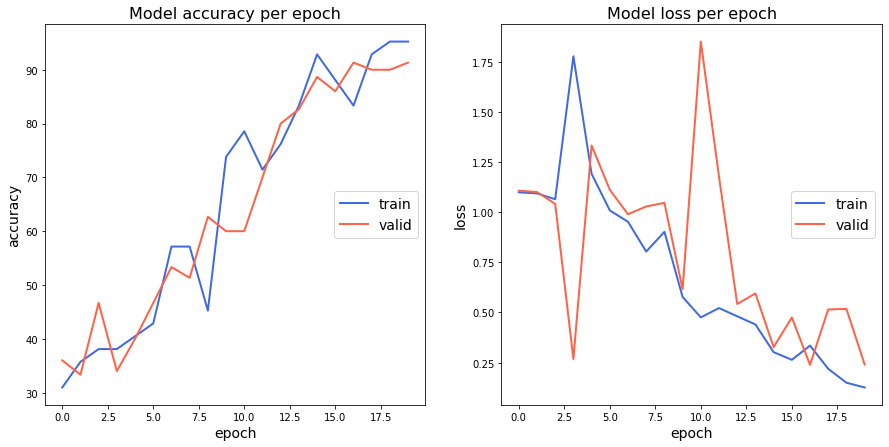

In [13]:
#Train and Valid Accuracy & Loss curve
#-------------------------------------------------------------------------------
print('\033[1m Accuracy for train dataset:{:.2f}%\033[0m'.format(List_acc_train[-1]))
print('\033[1m Accuracy for valid dataset:{:.2f}%\033[0m'.format(List_acc_valid[-1]))
print('\n')

#Accuracy curves
#-------------------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(List_acc_train,"royalblue",linewidth=2)
plt.plot(List_acc_valid,"tomato",linewidth=2)
plt.title('Model accuracy per epoch',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)

#Loss curves
#-------------------------------------------------------------------------------
plt.subplot(122)
plt.plot(List_loss_train,"royalblue",linewidth=2)
plt.plot(List_loss_valid,"tomato",linewidth=2)
plt.title('Model loss per epoch',fontsize=16)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)
plt.show()

In [14]:
PATH = './plant3_AlexNet_full.pth'
AlexNet = torch.load(PATH)

In [ ]:
PATH = './plant3_AlexNet_full.pth'